## Evaluate a model

In [24]:
using GTFConv
using BSON: load
using JSON
using Plots
load_model(path::String;mod=@__MODULE__) = load(path, mod)[:model]

load_model (generic function with 1 method)

In [25]:
run_path = "Results/Lorenz/test/001" #path of test model
model_path = run_path*"/checkpoints/model_1000.bson" #combine total path with relative path
dataset_path = run_path*"/args.json"

#load dataset
args = JSON.parsefile(dataset_path)
device = get_device(args)
dataset = load_dataset(args; device = device) |> device
#load PLRNN and observation model
model, O = load_model(model_path;mod) 

No path to external inputs or nuisance artifacts provided, initializing vanilla Dataset.


2-element Vector{Any}:
 clippedShallowPLRNN{Vector{Float32}, Matrix{Float32}}(Float32[0.8169833, 0.94814163, 0.7713585], Float32[-0.057448775 -0.10773403 … -0.097689986 -0.09214722; -0.09089048 -0.15781981 … 0.1444405 -0.35781896; -0.25245824 -0.2479856 … -0.13786425 0.13896106], Float32[-0.45492542 0.33437783 0.02051182; -0.4692221 0.34584656 -0.2402242; … ; 0.562409 -0.33711365 0.31274098; 0.4989305 -0.22001024 -0.05256044], Float32[0.04471236, 0.042337842, 0.07980536], Float32[-0.0984921, 0.124632, -0.52038324, 0.4195566, -0.28000325, 0.089093424, -0.2725464, 0.3923621, -0.12450203, 0.40704334  …  -0.21165362, 0.28695646, -0.3939604, 0.35784978, -0.3946078, -0.84595156, 0.13533622, 0.17571974, 0.15441518, -0.41002643], nothing)
 Identity{Matrix{Float32}, Vector{Float32}, Nothing}(Float32[1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], Float32[0.0, 0.0, 0.0], false, nothing)

In [26]:
#load dataset time series and important values
X, X_test= dataset.X, dataset.X_test
X_total = vcat(X, X_test)
T = size(X_total, 1); #total number of time points in time series

In [27]:
#generate trajectory
z₁ = init_state(O, X[1,:]) #initial init_state
Z = generate(model, z₁, T)
X_gen = permutedims(O(Z'), (2, 1));

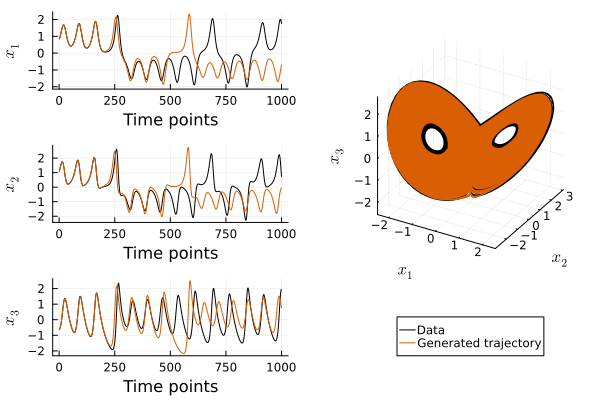

In [28]:
#Plotting
T_plot = 1000
p1 = plot(X_total[1:T_plot, :], label="Data", color = :black, layout=(3,1))
plot!(p1, X_gen[1:T_plot, :], label = "Generated trajectory", color="#d95f02")
plot!(p1, ylabel=["\$ x_1 \$" "\$ x_2 \$" "\$ x_3 \$"], xlabel="Time points")
plot!(p1, legend=false)

p2 = plot(X_total[:, 1], X_total[:, 2], X_total[:, 3], label="Data", color = :black)
plot!(p2, X_gen[:, 1], X_gen[:, 2], X_gen[:, 3], label = "Generated trajectory", color="#d95f02")
plot!(p2, xlabel="\$ x_1 \$", ylabel = "\$ x_2 \$", zlabel = "\$ x_3 \$")
plot!(p2, legend=:outerbottom)

plot(p1, p2)

In [29]:
#compute measures
measure_settings = Dict("Dstsp" => 1.0f0, "PSE" => 1.0f0, "PE" => 10)
# dstsp
Dstsp = state_space_distance(X_total, X_gen, measure_settings["Dstsp"])
# pse
PSE, _ = power_spectrum_error(X_total, X_gen, measure_settings["PSE"])
# PE
PE_train = prediction_error(dataset, model, O, X, measure_settings["PE"])
PE_test = prediction_error(dataset, model, O, X_test, measure_settings["PE"])

println("Dstsp: ", Dstsp, ", PSE: ",PSE, ", PE (train): ", PE_train, ", PE (test): ", PE_test)

Dstsp: 0.0009768995, PSE: 0.2570295, PE (train): 0.00013429504, PE (test): 0.00018784299
